In [ ]:
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import diffprivlib.models as dp
from sklearn.linear_model import LinearRegression


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model

dataset = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2)


In [ ]:
X_train.shape

(120, 4)

In [ ]:
X_train.max(0)

array([7.7, 4.4, 6.7, 2.5])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
## reading the data from each client
K = 25 # as we have 25 clients

clients = {} # dictionary
clients_cut = {}
for st_code in range(101,126):
    clients[st_code] = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataNew/station_code"+str(st_code)+".csv", index_col = 0)

    clients[st_code]['Measurement date'] = pd.to_datetime(clients[st_code]['Measurement date'])
    clients[st_code]['st_code'] = st_code

    clients[st_code]['year'] = clients[st_code]['Measurement date'].dt.year
    clients[st_code]['month'] = clients[st_code]['Measurement date'].dt.month
    clients[st_code]['week'] = clients[st_code]['Measurement date'].dt.week
    clients[st_code]['day'] = clients[st_code]['Measurement date'].dt.day
    clients[st_code]['hour'] = clients[st_code]['Measurement date'].dt.hour
    clients[st_code]['minute'] = clients[st_code]['Measurement date'].dt.minute # minute is not significant; as only 0 values
    clients[st_code]['dayOfWeek'] = clients[st_code]['Measurement date'].dt.dayofweek

    # choosing features
    clients[st_code] = clients[st_code][['st_code','Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek', 'CO']]

    clients[st_code].drop(clients[st_code][clients[st_code]['CO'] < 0].index, axis=0, inplace=True)


# complete dataset
frames = list(clients.values())
dataset = pd.concat(frames)
# display(dataset)

<ipython-input-7-2a2b8dc8e154>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  clients[st_code]['week'] = clients[st_code]['Measurement date'].dt.week
<ipython-input-7-2a2b8dc8e154>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  clients[st_code]['week'] = clients[st_code]['Measurement date'].dt.week
<ipython-input-7-2a2b8dc8e154>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  clients[st_code]['week'] = clients[st_code]['Measurement date'].dt.week
<ipython-input-7-2a2b8dc8e154>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  clients[st_code]['week'] = clients[st_code]['Measurement date'].dt.week
<ipython-input-7-2a2b8dc8e154>:14: FutureWarning: Series.dt.

In [ ]:
np.unique(dataset['st_code'])

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125])

In [ ]:
dataset.drop(columns=['st_code'], inplace=True)

In [ ]:
dataset.max(0)

Latitude       37.658774
Longitude     127.136792
year         2019.000000
month          12.000000
week           52.000000
day            31.000000
hour           23.000000
dayOfWeek       6.000000
PM2.5        6256.000000
dtype: float64

In [ ]:
dataset.count()

Latitude     643538
Longitude    643538
year         643538
month        643538
week         643538
day          643538
hour         643538
dayOfWeek    643538
PM2.5        643538
dtype: int64

In [ ]:
dataset.corr()

,Latitude,Longitude,year,month,week,day,hour,dayOfWeek,PM2.5
Latitude,1.000000,0.308139,0.000553,-0.000498,-0.000518,-0.000282,-0.000193,-0.000243,-0.022974
Longitude,0.308139,1.000000,0.000626,0.001317,0.001353,0.000343,-0.000124,0.000062,-0.019747
year,0.000553,0.000626,1.000000,0.004941,0.001507,0.007527,0.000588,-0.008095,0.030772
month,-0.000498,0.001317,0.004941,1.000000,0.976253,0.012856,0.000213,0.008825,-0.105946
week,-0.000518,0.001353,0.001507,0.976253,1.000000,0.074680,0.000252,0.007187,-0.102219
day,-0.000282,0.000343,0.007527,0.012856,0.074680,1.000000,0.000100,-0.002689,0.005094
hour,-0.000193,-0.000124,0.000588,0.000213,0.000252,0.000100,1.000000,-0.001707,0.033788
dayOfWeek,-0.000243,0.000062,-0.008095,0.008825,0.007187,-0.002689,-0.001707,1.000000,-0.005628
PM2.5,-0.022974,-0.019747,0.030772,-0.105946,-0.102219,0.005094,0.033788,-0.005628,1.000000


In [ ]:
# import modules
import matplotlib.pyplot as mp
import seaborn as sb
def heatcor(df):
  # plotting correlation heatmap
  dataplot = sb.heatmap(round(df.corr(),3), cmap="YlGnBu", annot=True)

  # displaying heatmap
  mp.show()


In [ ]:
# two new datasets
dataset_m = dataset.drop(columns='week')
dataset_w = dataset.drop(columns='month')

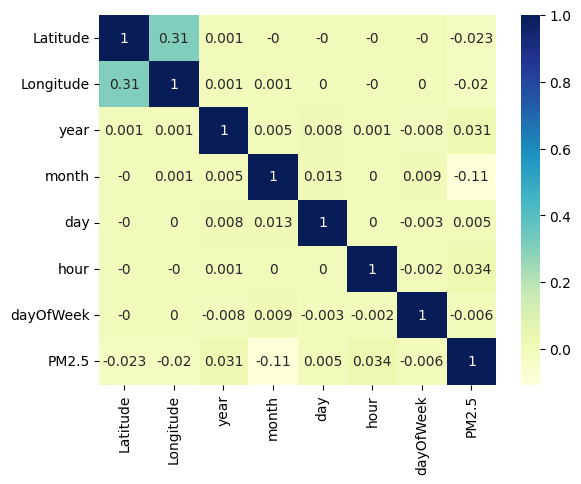

In [ ]:
heatcor(dataset_m)

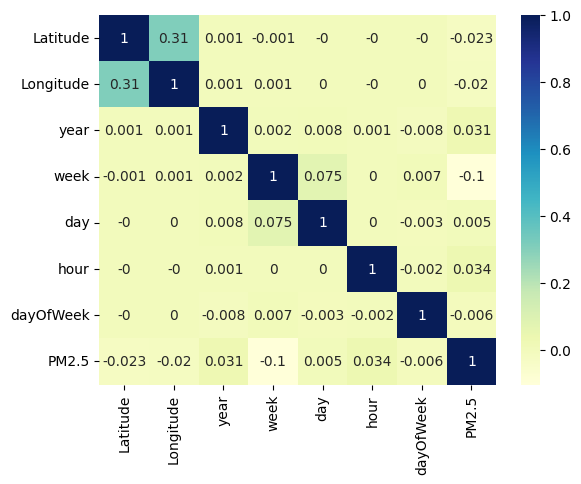

In [ ]:
heatcor(dataset_w)

In [ ]:
dataset_m.describe()

,Latitude,Longitude,year,month,day,hour,dayOfWeek,PM2.5
count,643538.000000,643538.000000,643538.000000,643538.000000,643538.000000,643538.000000,643538.000000,643538.000000
mean,37.553468,126.989437,2017.981979,6.539162,15.773942,11.501075,2.990889,25.575054
std,0.053325,0.078851,0.813042,3.453538,8.825297,6.919041,2.000908,44.010772
min,37.452357,126.835151,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,37.517528,126.927102,2017.000000,4.000000,8.000000,6.000000,1.000000,11.000000
50%,37.544962,127.004850,2018.000000,7.000000,16.000000,11.000000,3.000000,19.000000
75%,37.584848,127.047470,2019.000000,10.000000,23.000000,17.000000,5.000000,31.000000
max,37.658774,127.136792,2019.000000,12.000000,31.000000,23.000000,6.000000,6256.000000


###### Logistic Regression Implementation Without Privacy

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# import diffprivlib.models as dp
# from sklearn.linear_model import LogisticRegression


# X, y = dataset[['Latitude', 'Longitude','year', 'month', 'week', 'day', 'hour', 'dayOfWeek']],  dataset['CO']

# x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1)

# clf = LogisticRegression(solver="lbfgs")
# clf.fit(x_train, y_train)
# baseline = clf.score(X_test, y_test)
# print("Non-private test accuracy: %.2f%%" % (baseline * 100))



KeyError: ignored

# Linear Regression Non Private

In [ ]:
# dataset_m
# preprocessing

#1. train test splits
X, y = dataset_m[['Latitude', 'Longitude','year', 'month','day', 'hour', 'dayOfWeek']],  dataset_m['CO']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

#2. Feature Scaling
scaler_cols = x_train.columns
scaler_idx_train = x_train.index
scaler_idx_test = x_test.index

# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# transforming train data
x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
# display(x_train_encoded_scaled.head())

# transforming test data
x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
# display(x_test_encoded_scaled.head())


In [ ]:
def getDataAccordingToLossP(loss_p, gas):
  X, y = dataset_m[['Latitude', 'Longitude','year', 'month','day', 'hour', 'dayOfWeek']],  dataset_m[gas]
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = loss_p, random_state=1)
  #2. Feature Scaling
  scaler_cols = x_train.columns
  scaler_idx_train = x_train.index
  scaler_idx_test = x_test.index

  # from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()

  # transforming train data
  x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = scaler_cols, index=scaler_idx_train)
  # display(x_train_encoded_scaled.head())

  # transforming test data
  x_test_encoded_scaled = pd.DataFrame(scaler.transform(x_test), columns = scaler_cols, index = scaler_idx_test)
  # display(x_test_encoded_scaled.head())
  return x_train_encoded_scaled,x_test_encoded_scaled,y_train, y_test


In [ ]:
import statsmodels.api as sm
np.random.seed(9876789)

X_reg = sm.add_constant(x_train_encoded_scaled)
# y = np.dot(X, beta) + e


model = sm.OLS(y_train, X_reg)
results = model.fit()

X_reg_test = sm.add_constant(x_test_encoded_scaled)
# y_pred = model.predict(X_reg)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2.5   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1037.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        06:48:59   Log-Likelihood:            -2.6795e+06
No. Observations:              514830   AIC:                         5.359e+06
Df Residuals:                  514822   BIC:                         5.359e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.3847      0.263    119.155      0.000      30.868      31.901
Latitude      -3.2946      0.250    -13.186      0.000      -3.784      -2.805
Longitude     -2.1516      0.247     -8.709      0.000      -2.636      -1.667
year           3.4540      0.151     22.859      0.000       3.158       3.750
month        -14.8643      0.196    -75.981      0.000     -15.248     -14.481
day            1.0826      0.209      5.185      0.000       0.673       1.492
hour           4.9455      0.204     24.225      0.000       4.545       5.346
dayOfWeek     -0.6025      0.184     -3.272      0.001      -0.963      -0.242
==============================================================================
Omnibus:                  1193433.061   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      27700624134.704
Skew:                          22.450   Prob(JB):                         0.00
Kurtosis:                    1138.479   Cond. No.                         8.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# regr = LinearRegression()
# regr.fit(x_train_encoded_scaled, y_train)
# y_pred_train = regr.predict(x_train_encoded_scaled)
# y_pred = regr.predict(x_test_encoded_scaled)
# baseline = round(regr.score(x_train_encoded_scaled, y_train),4)
# baseline = 0.014
# print("Non-private baseline R2 score: %.2f" % baseline)

In [ ]:

# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_pred, y_test)
# mse_train = mean_squared_error(y_pred_train, y_train)
# print("train mse: {}\n test mse: {}".format(mse_train, mse))

train mse: 1941.7861820650257
 test mse: 1780.9791337691263


In [ ]:
# from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_test, y_pred)
# nmae = mae/np.mean(y_test)
# mae_train = mean_absolute_error(y_train, y_pred_train)
# print("train mae: {}\n test mae: {}".format(mae_train, mae))
# print(nmae)

train mae: 15.266585953625942
 test mae: 15.209978284823624
0.5954037601418154


Non Private LR with NMAE

In [ ]:
from sklearn.metrics import mean_absolute_error
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nmae_nonpr_train = []
nmae_nonpr_test = []
regr_nonprivate = LinearRegression()
gas='CO'

for loss_p in loss_prob:
  x_train_encoded_scaled,x_test_encoded_scaled,y_train, y_test =getDataAccordingToLossP(loss_p, gas)
  regr_nonprivate.fit(x_train_encoded_scaled, y_train)

  y_pred_nonpri_train = regr_nonprivate.predict(x_train_encoded_scaled)
  y_pred_nonpri_test = regr_nonprivate.predict(x_test_encoded_scaled)

  mae_test = mean_absolute_error(y_test, y_pred_nonpri_test)
  nmae_test = mae_test/np.mean(y_test)
  nmae_nonpr_test.append(nmae_test)

  mae_train = mean_absolute_error(y_train, y_pred_nonpri_train)
  nmae_train = mae_train/np.mean(y_train)
  nmae_nonpr_train.append(nmae_train)



In [ ]:
nmae_nonpr_train

[0.3601899034911113,
 0.3602608674796999,
 0.3602498369243951,
 0.36021734175402653,
 0.36050429700119124,
 0.36019367813938785,
 0.3601534262785363,
 0.36009826963423003,
 0.36030670329310477]

In [ ]:
nmae_nonpr_test

[0.3574525503372158,
 0.358649508398084,
 0.35934690418483217,
 0.35970276164172493,
 0.3598830901488819,
 0.36018391724928095,
 0.35994841438308317,
 0.3599293505484554,
 0.35995303748231805]

In [ ]:
# 1-rss/tss = tss-rss/tss
# rss: sum((actual-pred)**2)
# tss: sum((actual-mean_actual)**2)

# Linear Regression Private

In [ ]:
# from diffprivlib.models import LinearRegression

# epsilons = np.linspace(10**-1,10**2,10**3)
# r2 = []
# mse_test_arr = []
# mse_train_arr = []

# for epsilon in epsilons:
#     regr = LinearRegression(epsilon=epsilon, bounds_X=(0, 1), bounds_y=(0, 6257.0), random_state =1)
#     regr.fit(x_train_encoded_scaled, y_train)
#     y_pred_pri = regr.predict(x_test_encoded_scaled)
#     y_pred_train_pri = regr.predict(x_train_encoded_scaled)
#     r2.append(regr.score(x_test_encoded_scaled, y_test))
#     mse_test_arr.append(mean_squared_error(y_pred_pri, y_test))
#     mse_train_arr.append(mean_squared_error(y_pred_train_pri, y_train))

Linear Regression with Differential Privacy, Calculation of Normalised mean error for PM2.5

In [ ]:
from diffprivlib.models import LinearRegression
from sklearn.metrics import mean_absolute_error
from statistics import mean

epsilons = np.linspace(10**-2,10**2,10**2)
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nmae_pr_train = {}
nmae_pr_test = {}
gas='CO'

for loss_p in loss_prob:
  x_train_encoded_scaled,x_test_encoded_scaled,y_train, y_test=getDataAccordingToLossP(loss_p,gas)
  train_error = {}
  test_error = {}
  for epsilon_idx in range(len(epsilons)):
      regr_pri = LinearRegression(epsilon=epsilons[epsilon_idx], bounds_X=(0, 1), bounds_y=(0, 6257.0), random_state =1)
      regr_pri.fit(x_train_encoded_scaled, y_train)

      y_pred_pri_test = regr_pri.predict(x_test_encoded_scaled)
      y_pred_pri_train = regr_pri.predict(x_train_encoded_scaled)

      test_error[epsilons[epsilon_idx]] = mean_absolute_error( y_test, y_pred_pri_test)/np.mean(y_test)
      train_error[epsilons[epsilon_idx]] = mean_absolute_error( y_train, y_pred_pri_train)/np.mean(y_train)

      nmae_pr_train[loss_p] = train_error
      nmae_pr_test[loss_p] = test_error

In [ ]:
nmae_pr_test

{0.1: {0.01: 975.0214961508275,
  1.02: 9.796152387780255,
  2.03: 4.9310824386786365,
  3.04: 3.3020442113317285,
  4.05: 2.4882374235921727,
  5.06: 2.001646651606512,
  6.07: 1.679053896572655,
  7.08: 1.4502398285997868,
  8.09: 1.2800782890578961,
  9.1: 1.149000015600624,
  10.11: 1.0452366801589867,
  11.12: 0.9613191964989898,
  12.13: 0.8922633038062758,
  13.14: 0.8346656642994118,
  14.15: 0.7860640994182456,
  15.16: 0.7446332475273606,
  16.17: 0.708949956116051,
  17.180000000000003: 0.6779680768196131,
  18.19: 0.650877279405299,
  19.200000000000003: 0.6270617477036892,
  20.21: 0.6060141400253106,
  21.220000000000002: 0.5873161410311534,
  22.23: 0.5706101291687498,
  23.240000000000002: 0.5556195238226139,
  24.250000000000004: 0.5421194288215255,
  25.26: 0.5299090511973774,
  26.270000000000003: 0.5188242698163975,
  27.28: 0.5087464937453267,
  28.290000000000003: 0.4995510005555746,
  29.3: 0.491136204339137,
  30.310000000000002: 0.48342891588412856,
  31.32: 0.

In [ ]:
# ## Figuring out top 10 key,value (i.e., epsilon, error) for each loss probability
# nmae_pr_train_sorted = {}
# nmae_pr_test_sorted = {}

# for loss_p in nmae_pr_train:
#   nmae_pr_train_sorted[loss_p] = dict(sorted(nmae_pr_train[loss_p].items(), key = lambda x: x[1])[:1]) #sorting based on keys
#   nmae_pr_test_sorted[loss_p] = dict(sorted(nmae_pr_test[loss_p].items(), key = lambda x: x[1])[:1])

In [ ]:
# ## Figuring out top 10 key,value (i.e., epsilon, error) for each loss probability
# nmae_pr_train_sorted_re = {}
# nmae_pr_test_sorted_re = {}

# for loss_p in nmae_pr_train:
#   nmae_pr_train_sorted_re[loss_p] = dict(sorted(nmae_pr_train[loss_p].items(), key = lambda x: x[1], reverse=True)[:10]) #sorting based on keys
#   nmae_pr_test_sorted_re[loss_p] = dict(sorted(nmae_pr_test[loss_p].items(), key = lambda x: x[1], reverse=True)[:10])

In [ ]:
# nmae_pr_test_sorted

#### Preparing Graph Data

In [ ]:
# [a[0] for a in [list(val.keys()) for key, val in nmae_pr_train_sorted.items()]]
# [a[0] for a in [list(val.values()) for key, val in nmae_pr_train_sorted.items()]]

[0.5968299094558805,
 0.5968567392646135,
 0.5978130999224506,
 0.5975545853832783,
 0.5974136255334987,
 0.5986443244544988,
 0.5988694044504632,
 0.5960668904067207,
 0.6036674893707709]

In [ ]:
loss_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nmae_nonpr_train
nmae_nonpr_test

eps = [2.03,5.06,10.11,50.51,100.0]
nmae_pri_test = {}

for ep in eps:
  for lp in loss_prob:
    if ep in nmae_pri_test:
      nmae_pri_test[ep].append(nmae_pr_test[lp][ep])
    else:
      nmae_pri_test[ep] = []
      nmae_pri_test[ep].append(nmae_pr_test[lp][ep])

nmae_pri_test['TL'] = nmae_nonpr_test
# nmae_pr_train_sorted_eplison = [a[0] for a in [list(val.keys()) for key, val in nmae_pr_train_sorted.items()]]
# nmae_pr_train_sorted_nmae = [a[0] for a in [list(val.values()) for key, val in nmae_pr_train_sorted.items()]]
# nmae_pr_test_sorted_eplison = [a[0] for a in [list(val.keys()) for key, val in nmae_pr_test_sorted.items()]]
# nmae_pr_test_sorted_nmae = [a[0] for a in [list(val.values()) for key, val in nmae_pr_test_sorted.items()]]

In [ ]:
nmae_pri_test

<ipython-input-20-56e10390fd65>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


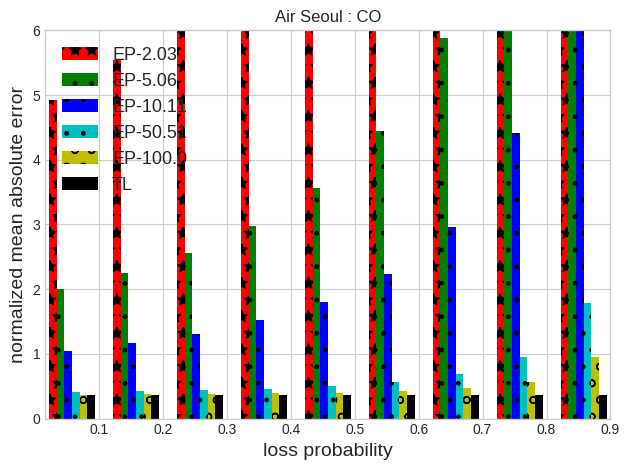

In [ ]:
import matplotlib.pyplot as plt

plt.title("Air Seoul : CO")
x = np.arange(len(loss_prob))  # the label locations which is the range of loss probs 0.1, 0.3, 0.5, ...
width = 0.12  # the width of the bars
marker_list = ['x','o','s','^','v','+','*'] # s is for square
color_list = ['r','g','b','c','k','y','m'] # m: magenta, : black
t_list = ['EP-2.03', 'EP-5.06', 'EP-10.11', 'EP-50.51', 'EP-100.0']
no_t_values = len(t_list)
label_size= 14

plt.style.use('seaborn-whitegrid')
#rects1 = ax.bar(x - width/2, y[0], width, label = algo_list[0], hatch='-')
# plt.bar(x,nmae_pri_test[0.01], width, label = t_list[0], hatch='O', color=color_list[0])
plt.bar(x + width, nmae_pri_test[2.03], width, label = t_list[0], hatch='*', color=color_list[0])
plt.bar(x + 2*width, nmae_pri_test[5.06], width, label = t_list[1], hatch='.', color=color_list[1])
plt.bar(x + 3*width, nmae_pri_test[10.11], width, label = t_list[2], hatch='.', color=color_list[2])
plt.bar(x + 4*width, nmae_pri_test[50.51], width, label = t_list[3], hatch='.', color=color_list[3])
plt.bar(x + 5*width, nmae_pri_test[100.0], width, label = t_list[4], hatch='o', color=color_list[5])
# plt.bar(x + 4*width, y[4], width, label = t_list[4], hatch='x', color=color_list[4])
plt.bar(x + 6*width, nmae_pri_test['TL'], width, label = 'TL', hatch='-', color=color_list[4])
'''
plt.bar(x + 6*width, y[6], width, label = t_list[6], hatch='+', color=color_list[6])
'''

'''
plt.xlabel("loss probability", fontsize = 'x-large')
plt.ylabel("normalized mean absolute error",fontsize = 'x-large')
'''
plt.xlabel("loss probability", fontsize = label_size)
plt.ylabel("normalized mean absolute error",fontsize = label_size)
#plt.axis([0.0,1.0,0.0,1], fontsize = 'x-large' )
temp_array = np.zeros((4,1))
temp_array[0] = 0.0
temp_array[1] =1.2
temp_array[2] =0.0
temp_array[3] = 6
#print(temp_array)
#plt.axis(temp_array, fontsize = 'x-large' )
plt.axis(temp_array) #, fontsize = label_size+5

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xticks(x+7*width, loss_prob)
plt.legend(loc='upper left', prop={'size':13})
# supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
plt.tight_layout()
output_filename = gas+'_bars_varying_t_lossprob_vs_error.eps'
plt.savefig(output_filename, bbox_inches = 'tight')
plt.show()


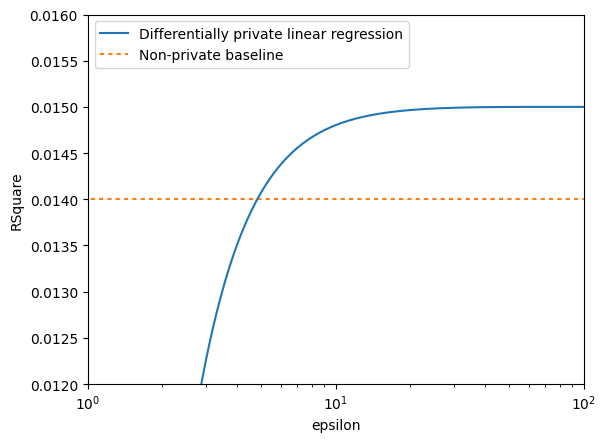

In [ ]:
# import matplotlib.pyplot as plt

# plt.semilogx(epsilons, r2, label="Differentially private linear regression", zorder=10)
# plt.semilogx(epsilons, baseline * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
# plt.xlabel("epsilon")
# plt.ylabel("RSquare")
# plt.ylim(0.011999, 0.016)
# plt.xlim(1, 100)
# plt.legend(loc=2)

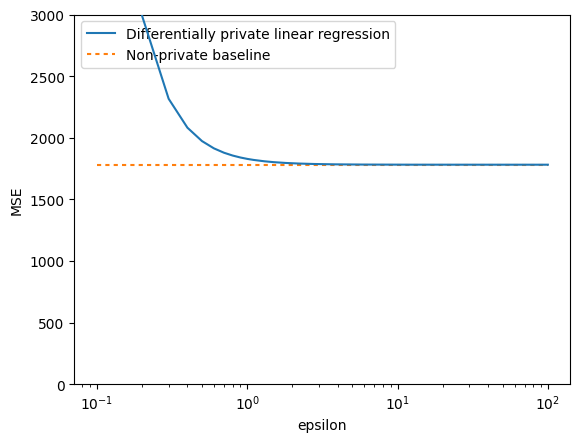

In [ ]:
# import matplotlib.pyplot as plt

# plt.semilogx(epsilons, mse_test_arr, label="Differentially private linear regression", zorder=10)
# plt.semilogx(epsilons, mse * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
# plt.xlabel("epsilon")
# plt.ylabel("MSE")
# plt.ylim(0, 3000)
# # plt.xlim(epsilons[0], epsilons[-9])
# plt.legend(loc=2)

In [ ]:
# import matplotlib.pyplot as plt

# plt.semilogx(epsilons, nmae_test_arr, label="Differentially private linear regression", zorder=10)
# plt.semilogx(epsilons, nmae * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
# plt.xlabel("epsilon")
# plt.ylabel("NMAE")
# # plt.ylim(0, 3000)
# # plt.xlim(epsilons[0], epsilons[-9])
# plt.legend(loc=2)

In [ ]:
plt.style.use('seaborn-whitegrid')
#rects1 = ax.bar(x - width/2, y[0], width, label = algo_list[0], hatch='-')
plt.bar(x,y[0], width, label = t_list[0], hatch='O', color=color_list[0])
plt.bar(x + width, y[1], width, label = t_list[1], hatch='*', color=color_list[1])
plt.bar(x + 2*width, y[2], width, label = t_list[2], hatch='.', color=color_list[2])
plt.bar(x + 3*width, y[3], width, label = t_list[3], hatch='o', color=color_list[3])
plt.bar(x + 4*width, y[4], width, label = t_list[4], hatch='x', color=color_list[4])
plt.bar(x + 5*width, y[5], width, label = 'TL', hatch='-', color=color_list[5])
'''